In [76]:
import time
from datetime import datetime
from tqdm.keras import TqdmCallback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Read in data

#
- https://blog.rmotr.com/bitcoin-trading-with-python-bollinger-bands-strategy-analysis-b1a223385a89

In [77]:
data = pd.read_csv("../data/localbtcUSD.csv", names=["datetime", "price", "volume"],
    index_col=0,
    parse_dates=True)

In [78]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3977580 entries, 1363046255 to 1546938874
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   price   float64
 1   volume  float64
dtypes: float64(2)
memory usage: 91.0 MB


In [79]:
data.index = pd.to_datetime(data.index, unit='s')

In [80]:
data.head()

,price,volume
datetime,,
2013-03-11 23:57:35,72.00,4.9999
2013-03-12 19:36:32,67.79,1.9999
2013-03-13 12:27:52,52.21,14.7684
2013-03-13 17:06:01,56.29,0.6401
2013-03-13 18:01:20,40.00,1.7500


In [81]:
data.tail()

,price,volume
datetime,,
2019-01-08 09:11:30,4057.75,0.024644
2019-01-08 09:12:14,6002.25,0.031655
2019-01-08 09:13:12,4293.61,0.132988
2019-01-08 09:13:44,4517.69,0.006641
2019-01-08 09:14:34,4170.85,0.235444


In [82]:
price_df = data.price.resample("D").ohlc()

### Candles

In [83]:
price_df.head()

,open,high,low,close
datetime,,,,
2013-03-11,72.00,72.00,72.00,72.00
2013-03-12,67.79,67.79,67.79,67.79
2013-03-13,52.21,56.29,40.00,40.00
2013-03-14,70.30,70.30,50.35,50.35
2013-03-15,49.52,70.96,47.75,48.41


## Calculate Bollinger Bands

In [84]:
# set number of days and standard deviations to use for rolling 
# lookback period for Bollinger band calculation
window = 60
no_of_std = 1.5

# calculate rolling mean and standard deviation
rolling_mean = price_df['close'].rolling(window).mean()
rolling_std = price_df['close'].rolling(window).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
price_df['Rolling Mean'] = rolling_mean
price_df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
price_df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

In [85]:
price_df.dropna(inplace=True)

In [86]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low
datetime,,,,,,,
2013-05-09,167.81,171.78,114.91,134.40,117.568167,185.480878,49.655456
2013-05-10,89.58,137.14,89.58,122.25,118.405667,185.727137,51.084196
2013-05-11,177.86,179.36,125.28,132.60,119.485833,186.115353,52.856314
2013-05-12,175.89,175.89,108.78,137.95,121.118333,185.967818,56.268849
2013-05-13,119.26,178.14,57.25,139.44,122.603167,186.024168,59.182166
...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571


In [87]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2013-05-09 to 2019-01-08
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            2011 non-null   float64
 1   high            2011 non-null   float64
 2   low             2011 non-null   float64
 3   close           2011 non-null   float64
 4   Rolling Mean    2011 non-null   float64
 5   Bollinger High  2011 non-null   float64
 6   Bollinger Low   2011 non-null   float64
dtypes: float64(7)
memory usage: 125.7 KB


<AxesSubplot:xlabel='datetime'>

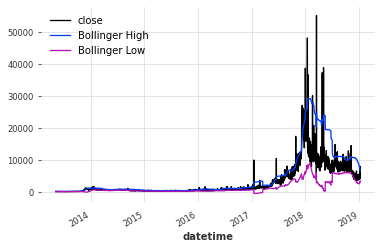

In [88]:
price_df[['close','Bollinger High','Bollinger Low']].plot()


In [89]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low
datetime,,,,,,,
2013-05-09,167.81,171.78,114.91,134.40,117.568167,185.480878,49.655456
2013-05-10,89.58,137.14,89.58,122.25,118.405667,185.727137,51.084196
2013-05-11,177.86,179.36,125.28,132.60,119.485833,186.115353,52.856314
2013-05-12,175.89,175.89,108.78,137.95,121.118333,185.967818,56.268849
2013-05-13,119.26,178.14,57.25,139.44,122.603167,186.024168,59.182166
...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571


<AxesSubplot:xlabel='datetime'>

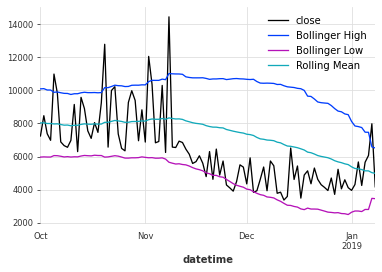

In [90]:
price_df[price_df.index >= '2018-10-01'][['close','Bollinger High','Bollinger Low', 'Rolling Mean']].plot()


### Train LSTM  /Darts

In [98]:
COLS = ['open',	'high',	'low',	'close',	'Rolling Mean',	'Bollinger High',	'Bollinger Low']
dataset_train = price_df[:int(price_df.shape[0]*0.8) ][COLS] 
dataset_test = price_df[int(price_df.shape[0]*0.8):][COLS]

In [99]:
price_df.head()

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low
datetime,,,,,,,
2013-05-09,167.81,171.78,114.91,134.40,117.568167,185.480878,49.655456
2013-05-10,89.58,137.14,89.58,122.25,118.405667,185.727137,51.084196
2013-05-11,177.86,179.36,125.28,132.60,119.485833,186.115353,52.856314
2013-05-12,175.89,175.89,108.78,137.95,121.118333,185.967818,56.268849
2013-05-13,119.26,178.14,57.25,139.44,122.603167,186.024168,59.182166


In [100]:
dataset_train.shape

(1608, 7)

In [102]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low
datetime,,,,,,,
2013-05-09,167.81,171.78,114.91,134.40,117.568167,185.480878,49.655456
2013-05-10,89.58,137.14,89.58,122.25,118.405667,185.727137,51.084196
2013-05-11,177.86,179.36,125.28,132.60,119.485833,186.115353,52.856314
2013-05-12,175.89,175.89,108.78,137.95,121.118333,185.967818,56.268849
2013-05-13,119.26,178.14,57.25,139.44,122.603167,186.024168,59.182166
...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571


In [104]:
series = TimeSeries.from_dataframe(price_df[COLS], value_cols='close', freq='D')

In [106]:
series

<TimeSeries (DataArray) (datetime: 2071, component: 1, sample: 1)>
array([[[ 134.4 ]],

       [[ 122.25]],

       [[ 132.6 ]],

       ...,

       [[6065.13]],

       [[7982.54]],

       [[4170.85]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 2013-05-09 2013-05-10 ... 2019-01-08
  * component  (component) object 'close'
Dimensions without coordinates: sample

In [107]:
# Set aside the last 36 days as a validation series
train, val = series.split_after(pd.Timestamp('2018-05-01'))

In [108]:
train.columns

Index(['close'], dtype='object', name='component')

In [109]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [110]:
series.start_time()

Timestamp('2013-05-09 00:00:00', freq='D')

In [111]:
datetime_attribute_timeseries?


Signature:
datetime_attribute_timeseries(
    time_index: Union[pandas.core.indexes.datetimes.DatetimeIndex, darts.timeseries.TimeSeries],
    attribute: str,
    one_hot: bool = False,
    cyclic: bool = False,
    until: Union[int, str, pandas._libs.tslibs.timestamps.Timestamp, NoneType] = None,
    add_length: int = 0,
) -> darts.timeseries.TimeSeries
Docstring:
Returns a new TimeSeries with index `time_index` and one or more dimensions containing
(optionally one-hot encoded or cyclic encoded) pd.DatatimeIndex attribute information derived from the index.


Parameters
----------
time_index
    Either a `pd.DatetimeIndex` attribute which will serve as the basis of the new column(s), or
    a `TimeSeries` whose time axis will serve this purpose.
attribute
    An attribute of `pd.DatetimeIndex` - e.g. "month", "weekday", "day", "hour", "minute", "second"
one_hot
    Boolean value indicating whether to add the specified attribute as a one hot encoding
    (results in more columns).
cycl

In [112]:
series.freq_str

'D'

In [114]:
# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=2500),
                                             attribute='year', one_hot=False)

In [115]:
year_series[:10]

<TimeSeries (DataArray) (time: 10, component: 1, sample: 1)>
array([[[2013.]],

       [[2013.]],

       [[2013.]],

       [[2013.]],

       [[2013.]],

       [[2013.]],

       [[2013.]],

       [[2013.]],

       [[2013.]],

       [[2013.]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-05-09 2013-05-10 ... 2013-05-18
  * component  (component) <U1 '0'
Dimensions without coordinates: sample

In [118]:
year_series = Scaler().fit_transform(year_series)

In [119]:
year_series[-10:]

<TimeSeries (DataArray) (time: 10, component: 1, sample: 1)>
array([[[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]],

       [[1.]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-03-03 2020-03-04 ... 2020-03-12
  * component  (component) object '0'
Dimensions without coordinates: sample

In [120]:
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)


In [121]:
month_series[:10]

<TimeSeries (DataArray) (time: 10, component: 12, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
...
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-05-09 2013-05-10 ... 2013-05-18
  * component  (component) object 'month_1' 'month_2' ... 'month_11' 'month_12'
Dimensions without coordinates: sample

In [122]:
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('2018-05-01'))#

In [123]:
covariates

<TimeSeries (DataArray) (time: 2500, component: 13, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
...
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-05-09 2013-05-10 ... 2020-03-12
  * component  (component) object '0' 'month_1' ... 'month_11' 'month_12'
Dimensions without coordinates: sample

In [124]:
# train model
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=200,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Air_RNN',
    log_tensorboard=False,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True
)

In [125]:
train_transformed.width

1

In [126]:
val_transformed.width

1

In [127]:
covariates

<TimeSeries (DataArray) (time: 2500, component: 13, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
...
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-05-09 2013-05-10 ... 2020-03-12
  * component  (component) object '0' 'month_1' ... 'month_11' 'month_12'
Dimensions without coordinates: sample

In [128]:
my_model.fit(train_transformed,
             future_covariates=covariates,
             val_series=val_transformed,
             val_future_covariates=covariates,
             verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

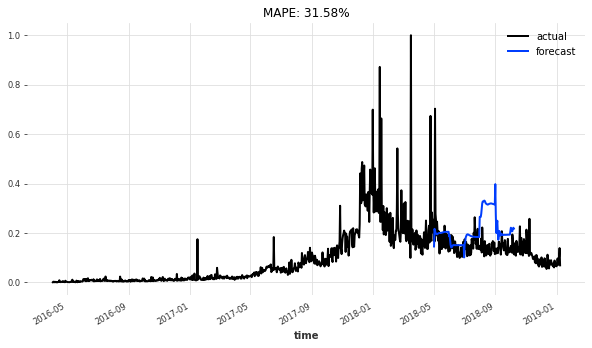

In [ ]:
pred_series = my_model.predict(n=160, future_covariates=covariates)
plt.figure(figsize=(10,5))
series_transformed.plot(label='actual')
pred_series.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
plt.legend();



In [72]:
pred_series

<TimeSeries (DataArray) (time: 16, component: 1, sample: 1)>
array([[[0.14521877]],

       [[0.21643455]],

       [[0.20720606]],

       [[0.20137876]],

       [[0.19711411]],

       [[0.19535162]],

       [[0.19435825]],

       [[0.19568314]],

       [[0.19737878]],

       [[0.19892704]],

       [[0.19966719]],

       [[0.19982095]],

       [[0.19971522]],

       [[0.1997187 ]],

       [[0.19998755]],

       [[0.20051699]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-05-02 2018-05-03 ... 2018-05-17
  * component  (component) object 'close'
Dimensions without coordinates: sample

## Working on a strategy

In [14]:
# create a new column in the DataFrame to hold positions information
price_df['Position'] = None

# fill our position column based on the following rules:
#     * set to short (-1) when the price hits the upper band
#     * set to long (1) when it hits the lower band       
mode = 'open'
for index in range(len(price_df)):
    if index == 0:
        continue

    row = price_df.iloc[index]
    prev_row = price_df.iloc[index - 1]

    # long?
    if mode == 'open' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
        price_df.iloc[index, price_df.columns.get_loc('Position')] = 1
        mode = 'close'

    # short?
    if mode == 'close' and row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
        price_df.iloc[index, price_df.columns.get_loc('Position')] = -1
        mode = 'open'

In [15]:
price_df.dropna(subset=['Position'])


,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position
datetime,,,,,,,,
2014-12-12,350.40,5000.00,314.75,336.24,578.86855,804.255574,353.481526,1
2015-05-31,248.43,927.64,195.76,511.95,326.14610,450.390794,201.901406,-1
2015-09-30,271.56,2617.80,201.41,203.00,303.63670,398.281866,208.991534,1
2015-10-03,248.57,2617.80,191.87,407.83,302.90670,397.546825,208.266575,-1
2018-11-21,6498.87,35999.95,3433.56,4625.66,8346.60400,11162.258646,5530.949354,1


## Visualize position

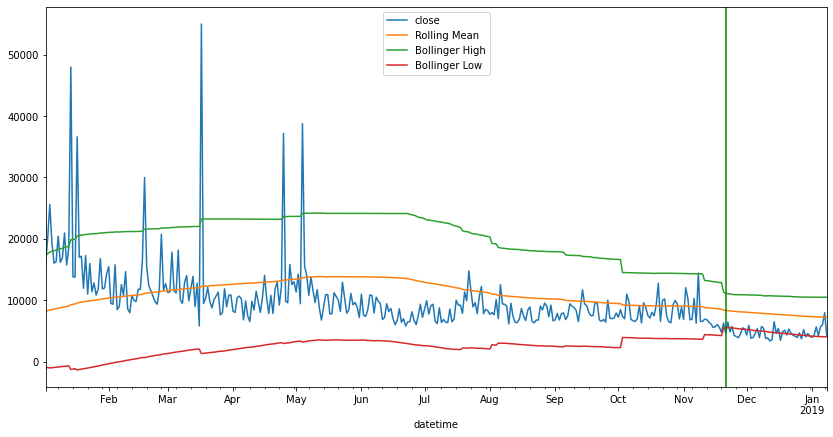

In [16]:

price_df[price_df.index > '2018-01-01'][['close', 'Rolling Mean', 'Bollinger High','Bollinger Low']].plot(figsize=(14, 7))

for index, pos in price_df[price_df.index > '2018-01-01'].dropna(subset=['Position'])['Position'].iteritems():
    plt.axvline(index, color='green' if pos == 1 else 'red')

<AxesSubplot:xlabel='datetime'>

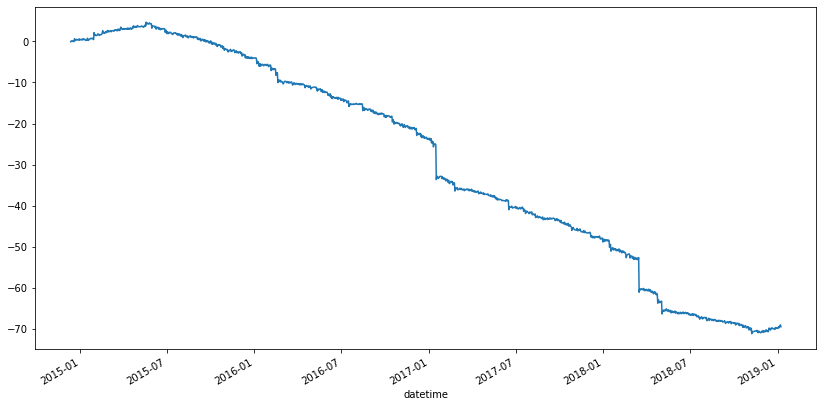

In [102]:
# forward fill our Position column to replace "None" values with the correct buy/sell 
# operations to represent the "holding" of our position forward through time
# price_df.dropna(inplace=True)
price_df['Position'].fillna(method='ffill', inplace=True)

# calculate the daily market return and multiply that by the position to determine strategy returns
price_df['Market Return'] = price_df['close'].pct_change()
price_df['Strategy Return'] = price_df['Market Return'] * price_df['Position']

# plot the strategy returns
price_df['Strategy Return'].cumsum().plot(figsize=(14, 7))

In [18]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2013-09-26,131.95,194.76,98.75,145.11,119.20890,164.312202,74.105598,NaN,NaN,NaN
2013-09-27,148.90,190.11,115.07,129.57,119.49675,164.331286,74.662214,NaN,-0.107091,NaN
2013-09-28,129.81,190.32,101.51,146.22,119.88890,164.471780,75.306020,NaN,0.128502,NaN
2013-09-29,134.18,254.00,114.30,150.18,120.43980,164.316448,76.563152,NaN,0.027082,NaN
2013-09-30,135.19,201.75,118.33,134.82,120.86215,164.123573,77.600727,NaN,-0.102277,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,7299.61170,10505.638173,4093.585227,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,7284.80430,10492.448657,4077.159943,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,7283.01505,10491.970786,4074.059314,1.0,0.072237,0.072237


# Finding a better configuration¶


In [19]:
data.head()

,price,volume
datetime,,
2013-03-11 23:57:35,72.00,4.9999
2013-03-12 19:36:32,67.79,1.9999
2013-03-13 12:27:52,52.21,14.7684
2013-03-13 17:06:01,56.29,0.6401
2013-03-13 18:01:20,40.00,1.7500


In [89]:
class BollingerBandsSimulator:

    def __init__(self, df_original, from_date, period, window, no_of_std, figsize=None):
        self.df = df_original
        self.from_date = from_date
        self.period = period
        self.window = window
        self.no_of_std = no_of_std
        self.figsize = figsize
    
    def _build_candles_dataframe(self):
        self.df = self.df.loc[self.from_date:, ["price"]].copy()
        self.df = self.df["price"].resample(self.period).ohlc()
                
    def _build_bollinger_bands(self):
        rolling_mean = self.df['close'].rolling(self.window).mean()
        rolling_std = self.df['close'].rolling(self.window).std()

        self.df['Rolling Mean'] = rolling_mean
        self.df['Bollinger High'] = rolling_mean + (rolling_std * self.no_of_std)
        self.df['Bollinger Low'] = rolling_mean - (rolling_std * self.no_of_std)

    def _calculate_positions(self):
        self.df['Position'] = None
        self.df['Mode'] = None
        self.number_of_trades = 0
        buy_has_crossed_mean = False
        short_has_crossed_mean = False


        mode = 'no_position'
        
        for index in range(len(self.df)):
            if index == 0:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] =  mode
                continue

            row = self.df.iloc[index]
            prev_row = self.df.iloc[index - 1]
            
            # get out of position if price crosses mean
            # (if mode == 'open' or mode == 'no_position' ) and 
            if mode == 'buy'  and row['close'] > row['Rolling Mean']:
                buy_has_crossed_mean = True
                
            if mode == 'short'  and row['close'] < row['Rolling Mean']:
                short_has_crossed_mean = True

            # open -> no_position? no position is below running mean
            if mode == 'buy'  and row['close'] < row['Rolling Mean'] and buy_has_crossed_mean:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 1
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy_to_no_position'
                self.number_of_trades  +=1
                mode = 'no_position'
                buy_has_crossed_mean = False
            
            # close -> no_position? no position if above running mean
            elif mode == 'short'  and row['close'] > row['Rolling Mean'] and short_has_crossed_mean:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short_to_no_position'
                self.number_of_trades  +=1
                mode = 'no_position'
                short_has_crossed_mean = False

            # buy
            elif mode == 'no_position' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 # buy. add one to index so that pct_change works
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 1 # buy. add one to index so that pct_change works
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy'
                self.number_of_trades  +=1
                mode = 'buy'     
        
            # short?
            elif mode == 'no_position' and  row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 #  short starts at the end of the day. Calculate pct_change starting tomorrow
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = -1 #  short starts at the end of the day. Calculate pct_change starting tomorrow
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short'
                self.number_of_trades  +=1
                mode = 'short' 
                       
            else:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = mode
        
    def _calculate_returns(self):
        
        self.df['Original Position'] = self.df['Position']
        self.df['Position'].fillna(method='ffill', inplace=True)
        self.df['Market Return'] = self.df['close'].pct_change()
        self.df['Strategy Return'] = self.df['Market Return'] * self.df['Position']

    def _plot_returns(self):
        self.df['Strategy Return'].cumsum().plot(figsize=self.figsize)
        

    def simulate(self):
        self._build_candles_dataframe()
        self._build_bollinger_bands()
        self._calculate_positions()
        self._calculate_returns()
        self._plot_returns()

        return (
            self.period, 
            self.window, 
            self.no_of_std, 
            self.df['Strategy Return'].sum(),
            self.number_of_trades
        )

('6H', 90, 1.5, 11.414849028617624, 255)

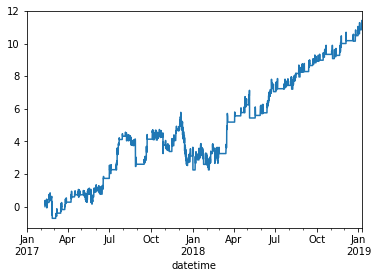

In [104]:

simulator = BollingerBandsSimulator(
    data, 
    from_date="2017-01-01", 
    period="6H", 
    window=90, 
    no_of_std=1.5
)
simulator.simulate()

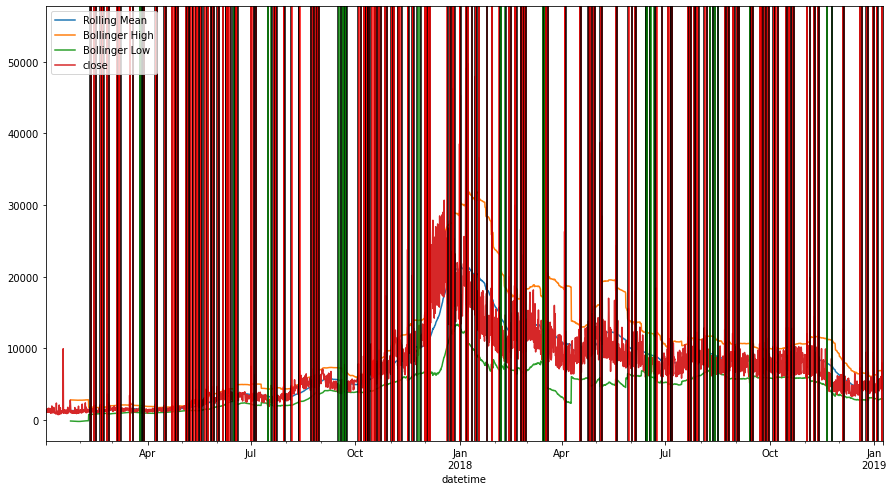

In [100]:
DATE_FILTER = '2017-01-01'
simulator.df[simulator.df.index > DATE_FILTER ]  [['Rolling Mean', 'Bollinger High', 'Bollinger Low', 'close']].plot(figsize=(15,8))

prev_pos = None
for index, pos in simulator.df[simulator.df.index > DATE_FILTER ]['Original Position'].iteritems():
    if pos == -1:
        plt.axvline(index, color='red')
    if pos == 1:
        plt.axvline(index, color='green')
    if pos == 0:
        plt.axvline(index, color='black')


In [101]:
simulator.df[simulator.df.index > "2017-12-25"].head(30)


,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Mode,Original Position,Market Return,Strategy Return
datetime,,,,,,,,,,,,
2017-12-25 06:00:00,22998.39,142744.99,13226.76,15583.99,19993.015556,27433.398577,12552.632534,0.0,no_position,None,-0.323671,-0.000000
2017-12-25 12:00:00,16054.50,55625.60,7348.57,21590.07,20000.516444,27443.779359,12557.253530,0.0,no_position,None,0.385401,0.000000
2017-12-25 18:00:00,20083.95,74999.06,10004.69,20499.99,20049.910444,27466.734194,12633.086695,0.0,no_position,None,-0.050490,-0.000000
2017-12-26 00:00:00,20499.99,75001.88,10190.19,46250.90,20402.000667,28847.187002,11956.814331,0.0,short,0,1.256143,0.000000
2017-12-26 06:00:00,22266.03,62000.12,13176.67,24322.97,20553.033667,28877.273698,12228.793635,-1.0,short,-1,-0.474108,0.474108
2017-12-26 12:00:00,35643.00,75997.08,12618.61,23136.83,20668.510444,28908.032312,12428.988577,-1.0,short,None,-0.048766,0.048766
2017-12-26 18:00:00,16131.86,75789.73,11926.97,25325.11,20737.292111,29005.766872,12468.817350,-1.0,short,None,0.094580,-0.094580
2017-12-27 00:00:00,16320.98,75001.88,12554.09,15899.99,20670.847333,28972.424136,12369.270531,-1.0,short,None,-0.372165,0.372165
2017-12-27 06:00:00,18999.08,77630.11,14754.72,23017.29,20812.117333,28954.135166,12670.099500,-1.0,short_to_no_position,-1,0.447629,-0.447629


In [61]:
simulator.df['Mode'].value_counts()

no_position           683
buy                    54
buy_to_no_position      1
Name: Mode, dtype: int64

# Brute force some configurations¶


In [19]:
 # generate a linear space of value values for each parameter in the configuration
# a take some random samples from them.
# for example the first one creates a vector of 5 evenly spaced integer values ranging from 10 to 100
windows = np.linspace(7, 90, 8, dtype=int)
stds = np.linspace(1.5, 2, 2)
periods = np.linspace(15 ,240, 6, dtype=int)

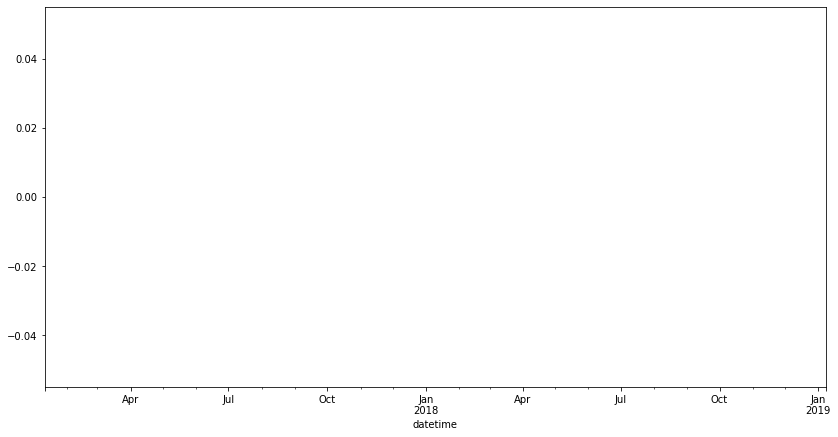

In [20]:
# iterate through them, running the strategy function each time and collecting returns
# (this might take some time)
simulations = []
result_df = pd.DataFrame({
    'period': [], 
    'window': [],
    'no_of_std': [],
    'result': []
})
for window in windows:
    for std in stds:
        for period in periods:
            simulator = BollingerBandsSimulator(
                data, 
                from_date="2017-01-11", 
                period="{}min".format(period), 
                window=window, 
                no_of_std=std,
                figsize=(14, 7)
            )
            period, window, no_of_std, result, total_trades = simulator.simulate()
            result_df = result_df.append({
                'period': period, 
                'window': window, 
                'no_of_std': no_of_std, 
                'result': result,
                'total_trades': total_trades
            }, ignore_index=True)
            simulations.append(simulator)

In [23]:
result_df.sort_values(by='result').tail(15) # Hours results in 1-2 trades. Test minutes

,period,window,no_of_std,result,total_trades
37,60min,42.0,1.5,0.0,0.0
36,15min,42.0,1.5,0.0,0.0
35,240min,30.0,2.0,0.0,0.0
34,195min,30.0,2.0,0.0,0.0
33,150min,30.0,2.0,0.0,0.0
32,105min,30.0,2.0,0.0,0.0
31,60min,30.0,2.0,0.0,0.0
30,15min,30.0,2.0,0.0,0.0
29,240min,30.0,1.5,0.0,0.0
28,195min,30.0,1.5,0.0,0.0


In [22]:
result_df.sort_values(by='result').tail(15).mean()

/var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/ipykernel_85509/3784085997.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_df.sort_values(by='result').tail(15).mean()


window          39.600000
no_of_std        1.766667
result           0.000000
total_trades     0.000000
dtype: float64

In [ ]:
WINNING_STRATEGY_INDEX = 30

### Look at the trading pattern for a winning strategy

In [ ]:
simulations[WINNING_STRATEGY_INDEX].df['Strategy Return'].cumsum()

datetime
2018-01-11 00:00:00         NaN
2018-01-11 06:40:00         NaN
2018-01-11 13:20:00         NaN
2018-01-11 20:00:00         NaN
2018-01-12 02:40:00         NaN
                         ...   
2019-01-07 02:40:00    2.798846
2019-01-07 09:20:00    3.080088
2019-01-07 16:00:00    3.041177
2019-01-07 22:40:00    3.071222
2019-01-08 05:20:00    3.091579
Freq: 400T, Name: Strategy Return, Length: 1305, dtype: float64

<AxesSubplot:xlabel='datetime'>

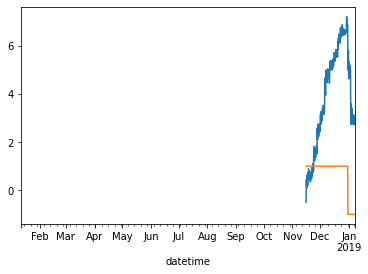

In [ ]:
simulations[WINNING_STRATEGY_INDEX].df['Strategy Return'].cumsum().plot()
simulations[WINNING_STRATEGY_INDEX].df['Position'].plot()

<AxesSubplot:xlabel='datetime'>

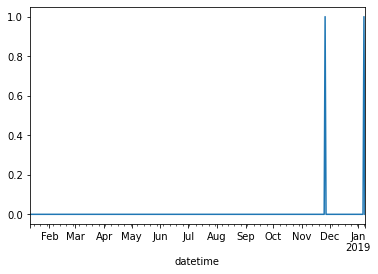

In [162]:
simulations[WINNING_STRATEGY_INDEX].df['Number of Trades'].plot()